In [12]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from sklearn import datasets

In [13]:
iris = datasets.load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


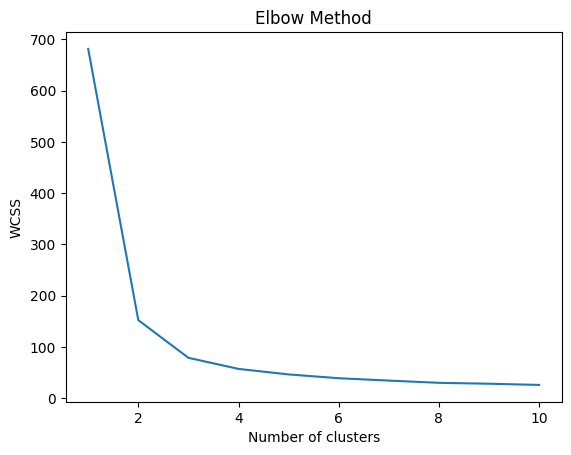

In [14]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


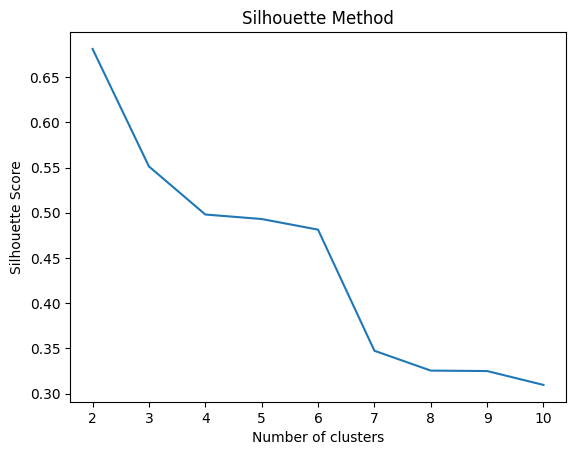

In [15]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(df)
    silhouette_scores.append(silhouette_score(df, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


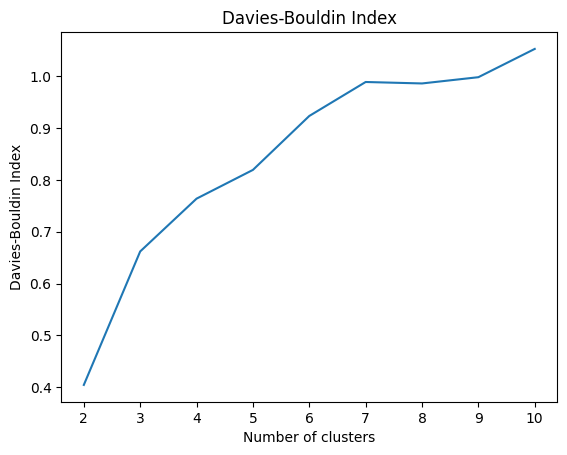

In [16]:
from sklearn.metrics import davies_bouldin_score

db_scores = []
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(df)
    db_scores.append(davies_bouldin_score(df, kmeans.labels_))

plt.plot(range(2, 11), db_scores)
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()


# Kmeans

In [17]:
# Choose the optimal number of clusters based on previous analyses, say k = 4
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df)
df['cluster'] = kmeans.labels_

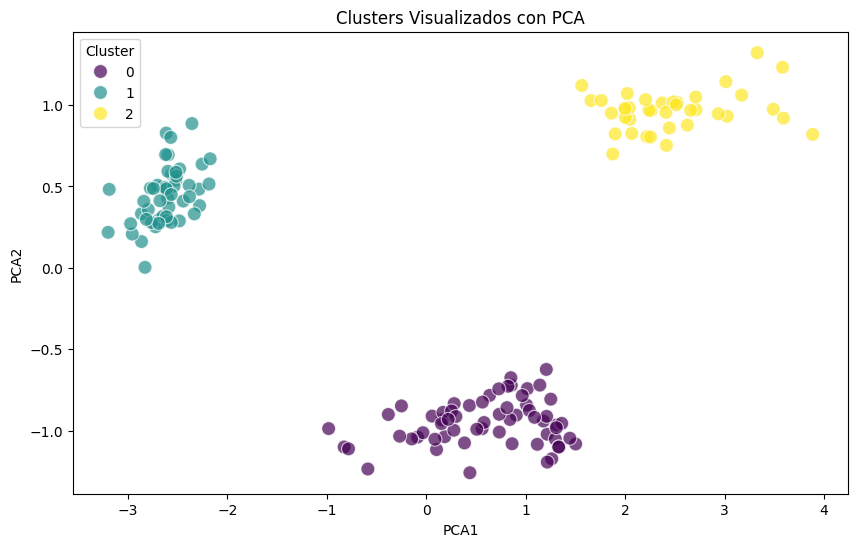

In [18]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df)

# Crear un DataFrame con las componentes principales y las etiquetas de los clusters
df_pca = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = kmeans.labels_

# Graficar los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', palette='viridis', data=df_pca, s=100, alpha=0.7)
plt.title('Clusters Visualizados con PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

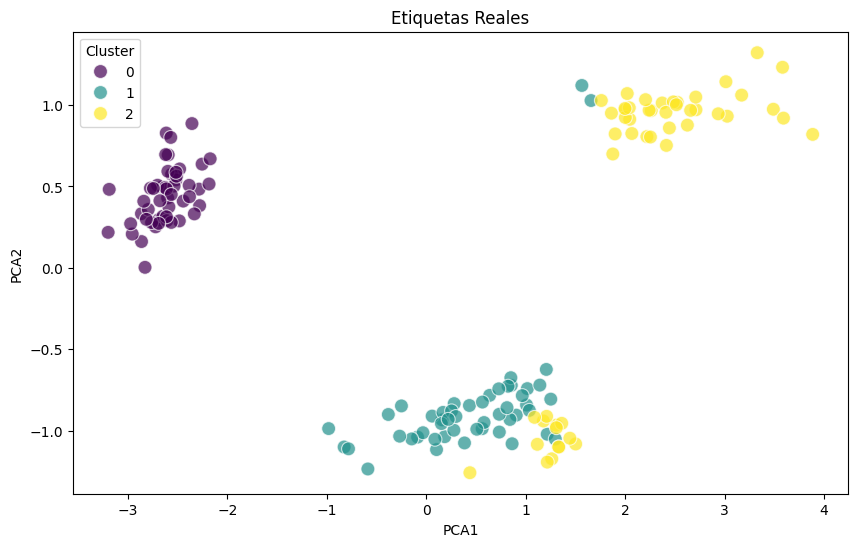

In [19]:
#comparar con las etiquetas reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=iris.target, palette='viridis', data=df_pca, s=100, alpha=0.7)
plt.title('Etiquetas Reales')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

Accuracy: 0.9666666666666667


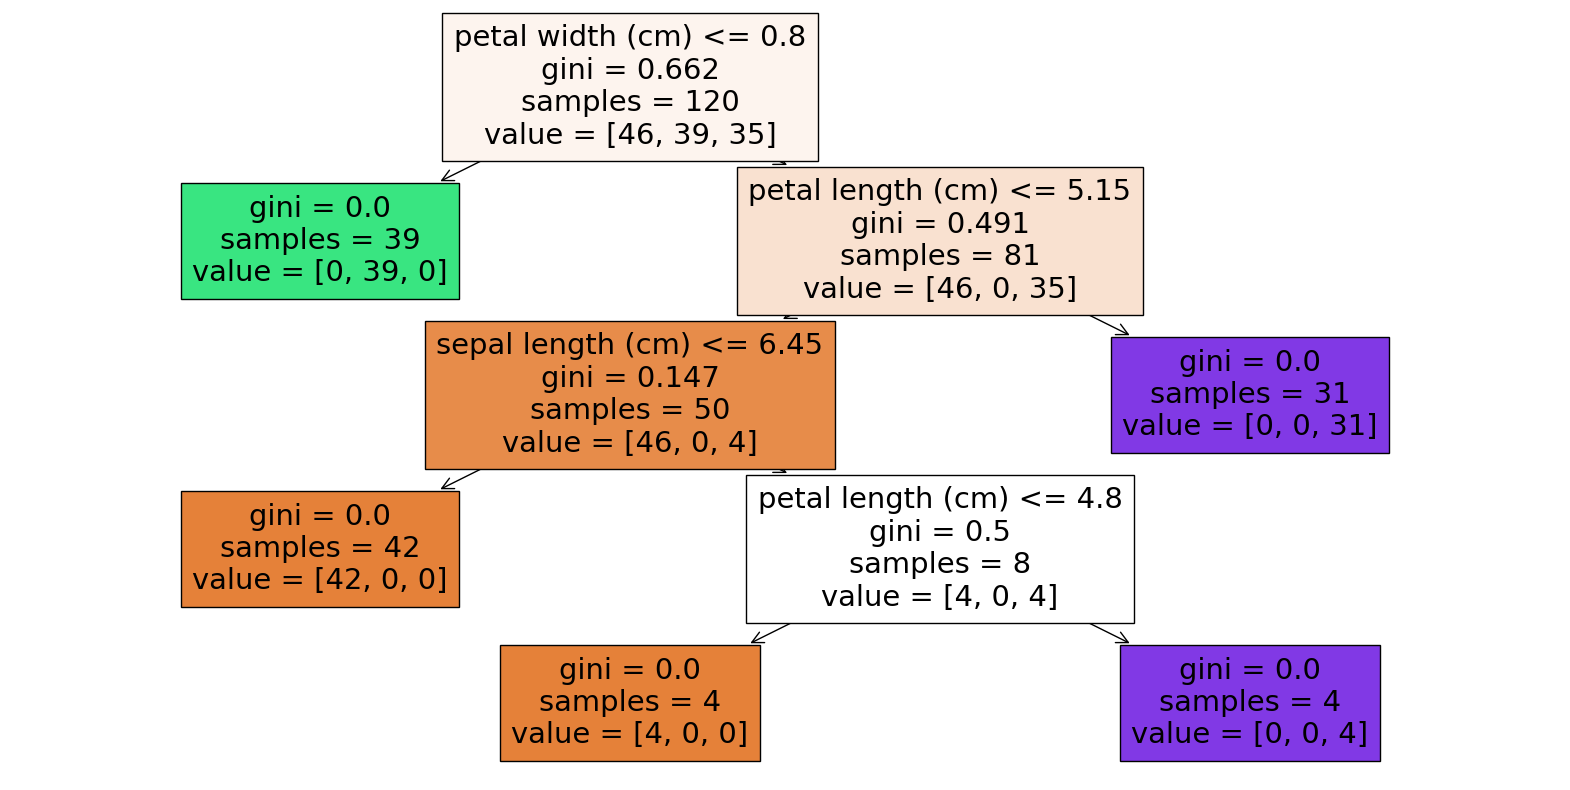

In [20]:
# evaluaemos con random forest si los clusters son buenos
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree

X = df.drop('cluster', axis=1)
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

""" rf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred)) """

#desicion tree
dt = DecisionTreeClassifier(max_depth=5, random_state=0)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
plt.figure(figsize=(20, 10))
tree.plot_tree(dt, filled=True, feature_names=iris.feature_names)
plt.show()

In [32]:
from dsgd.DSClassifierMultiQ import DSClassifierMultiQ
X_train_ds = X_train.to_numpy()
y_train_ds = y_train.to_numpy()
X_test_ds = X_test.to_numpy()
y_test_ds = y_test.to_numpy()


DSC = DSClassifierMultiQ(3, min_iter=20, max_iter=500, debug_mode=True, lr=0.005, 
                                lossfn="MSE", num_workers=1, min_dloss=1e-7, precompute_rules=True)

losses, epoch, dt = DSC.fit(X_train_ds, y_train_ds, add_single_rules=True,
                            single_rules_breaks=3, add_mult_rules=False,
                                column_names=iris.feature_names, print_every_epochs=1, print_final_model=False)
y_pred_ds = DSC.predict(X_test_ds)


Optimization started
Processing epoch	500	0.0146	
Training time: 34.49s, epochs: 500

Least training loss reached: 0.015


In [33]:
accuracy = accuracy_score(y_test_ds, y_pred_ds)
print('Accuracy:', accuracy)

Accuracy: 0.9666666666666667


In [35]:
DSC.print_most_important_rules(threshold=0.7)



Most important rules for class 0

	[0.892] R1: 5.310 < sepal length (cm) < 5.881
			0: 0.804	1: 0.187	2: 0.000	Unc: 0.009

	[0.838] R2: 5.881 < sepal length (cm) < 6.452
			0: 0.832	1: 0.000	2: 0.012	Unc: 0.156

	[0.785] R9: 2.617 < petal length (cm) < 3.816
			0: 0.785	1: 0.000	2: 0.000	Unc: 0.215

	[0.768] R10: 3.816 < petal length (cm) < 5.015
			0: 0.768	1: 0.000	2: 0.000	Unc: 0.232

	[0.744] R14: 1.232 < petal width (cm) < 1.752
			0: 0.715	1: 0.000	2: 0.058	Unc: 0.227

	[0.729] R13: 0.711 < petal width (cm) < 1.232
			0: 0.729	1: 0.000	2: 0.000	Unc: 0.271

Most important rules for class 1

	[0.738] R7: sepal width (cm) > 3.343
			0: 0.000	1: 0.587	2: 0.341	Unc: 0.072

	[0.717] R12: petal width (cm) < 0.711
			0: 0.000	1: 0.717	2: 0.000	Unc: 0.283

Most important rules for class 2

	[0.856] R11: petal length (cm) > 5.015
			0: 0.000	1: 0.000	2: 0.856	Unc: 0.144

	[0.774] R3: sepal length (cm) > 6.452
			0: 0.000	1: 0.000	2: 0.774	Unc: 0.226

	[0.728] R15: petal width (cm) > 1.75